# Analyse Long Format Dataset

In [1]:
# assert project root is cwd
import os
os.chdir('../..')

In [16]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
import pandas as pd
from src.d00_helpers import helpers as h
import seaborn as sns
from scipy.stats import ttest_ind
import numpy as np

In [3]:
# read in long dataframe

path_win='G://My Drive//Forschung//Mitarbeiter//Allgaier//23-12-06_Immun-ML//04_Data//01_processed//'
path_mac='/Users/johannesallgaier/My Drive/Forschung/Mitarbeiter/Allgaier/23-12-06_Immun-ML/04_Data/01_processed/'

name='2024.04.24_Mastertabelle'
df = pd.read_excel(path_win+f'{name}_long.xlsx',
                   parse_dates=['date'], index_col='Unnamed: 0', dtype={'vaccination': "Int64", 'infection':'Int64'})
df.rename(columns={'patient_id':'ID'}, inplace=True)

In [4]:
# read in baseline table to get demographic data
path_win='G://My Drive//Forschung//Mitarbeiter//Allgaier//23-12-06_Immun-ML//04_Data//00_raw//'
path_mac='/Users/johannesallgaier/My Drive/Forschung/Mitarbeiter/Allgaier/23-12-06_Immun-ML/04_Data/00_raw/'


bl = pd.read_excel(path_win+f'{name}.xlsx')
bl_sub=bl[['ID','Alter','Dialyse','Geschlecht']]

In [5]:
# Add information of Dialyse group
df = pd.merge(df, bl[['ID', 'Dialyse']], on='ID', how='left')

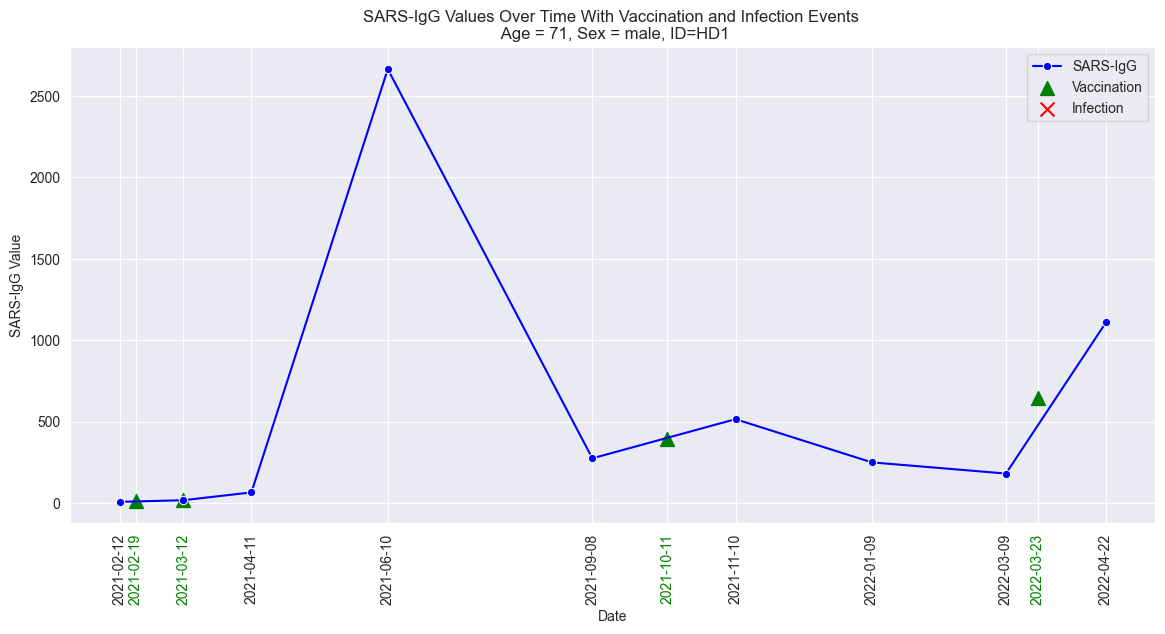

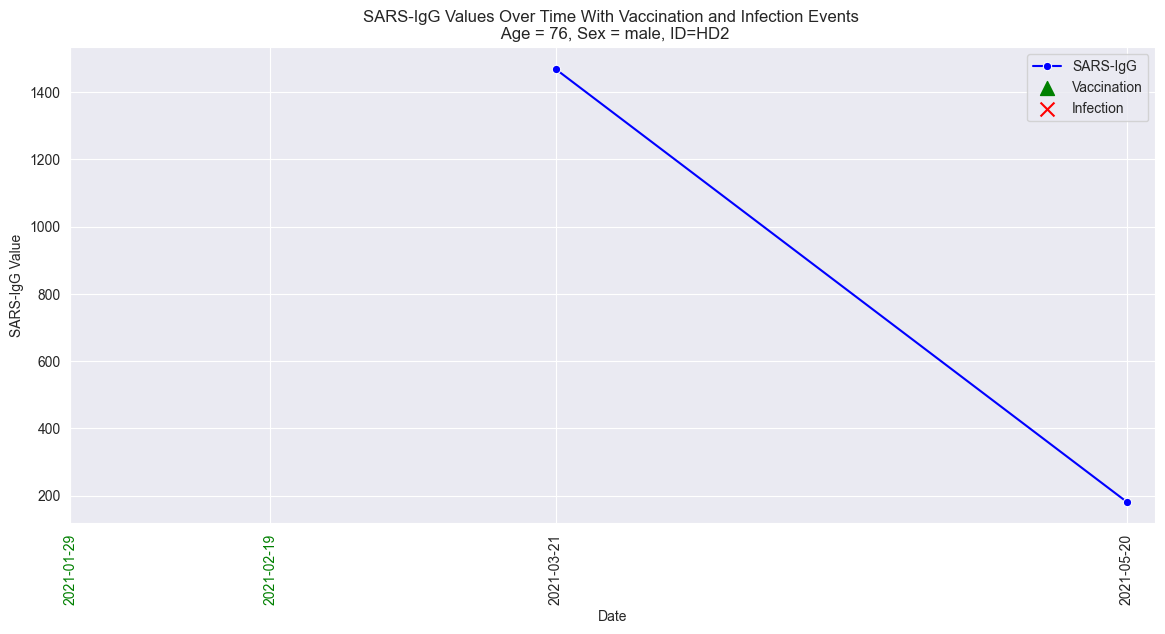

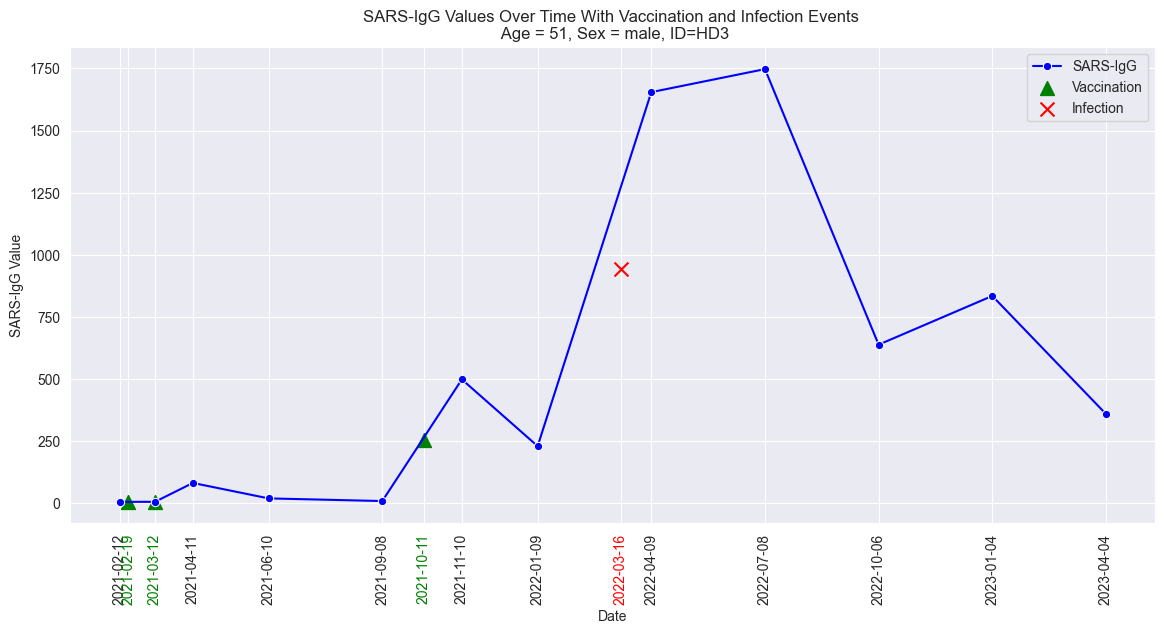

In [6]:
# loop over all patients and create single plots of their specific values
results_path = 'results/rq1/sars-igg-plots-by-patient'
for id in df.ID.unique()[:3]:
    bl_s = bl_sub[bl_sub['ID'] == id]
    df_s = df[df['ID'] == id]
    h.plot_sars_igg_with_events(df_s, results_path, bl_s, show_plot=True)

In [7]:
# reset index for easier mapping
bl = bl.set_index('ID')

# try to aggregate values and plot these on a time axis
vaccination_groups = dict(df.groupby(['ID'])['vaccination'].sum())
infection_groups = dict(df.groupby(['ID'])['infection'].sum())

In [8]:
# count number of vaccinations and infections
bl['n_vaccinations'] = None
for id in vaccination_groups.keys():
    bl.loc[id, 'n_vaccinations'] = vaccination_groups[id]

bl['n_infections'] = None
for id in infection_groups.keys():
    bl.loc[id, 'n_infections'] = infection_groups[id]

In [9]:
# merge this information into df
sub_df = pd.merge(df, bl[['n_vaccinations','n_infections']], how='left', left_on='ID', right_index=True)
# assign group ids
sub_df['group_id'] = sub_df.groupby(['Dialyse','n_vaccinations']).ngroup()

sub_res = sub_df[['group_id', 'Dialyse', 'n_vaccinations']].drop_duplicates()
group_id_dict = sub_res.set_index('group_id').to_dict(orient='index')

In [10]:
# sort by date and calculate n_vaccinations and n_infections until current date
sub_df = sub_df.sort_values(by='date')
sub_df['n_vaccinations_so_far'] = sub_df.groupby('ID')['vaccination'].cumsum()
sub_df['n_infections_so_far'] = sub_df.groupby('ID')['infection'].cumsum()

In [11]:
sub_df['event'] = sub_df['infection'] | sub_df['vaccination']

In [12]:
# Ensure the DataFrame is sorted by date
sub_df.sort_values(by='date', inplace=True)

# List to hold the DataFrame of each user after applying the function
dfs = []

# Group by user_id and apply the function to each group
for _, group in sub_df.groupby('ID'):
    group_result = h.calculate_days_since_last_event(group, event_col='event')
    dfs.append(group_result)

# Concatenate all the individual user DataFrames into a single DataFrame
result_df = pd.concat(dfs, ignore_index=True)

## What is the correlation of SARS-IgG and days sind last event?

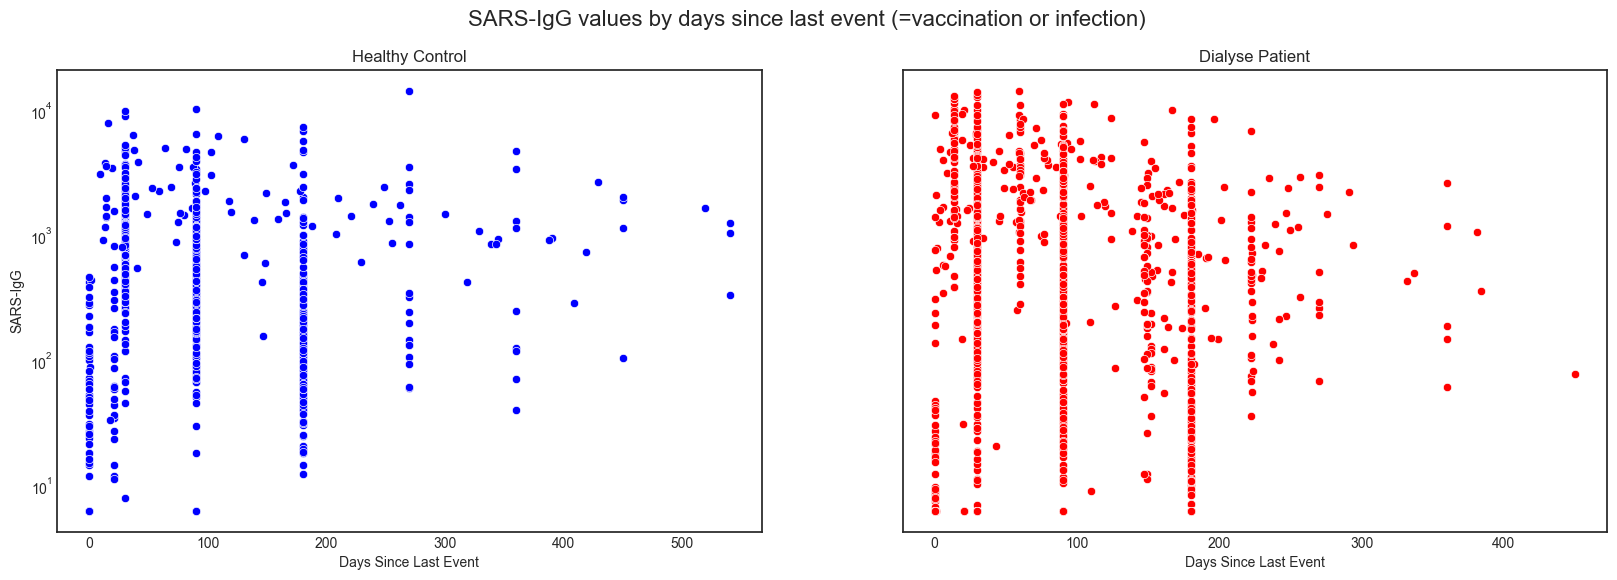

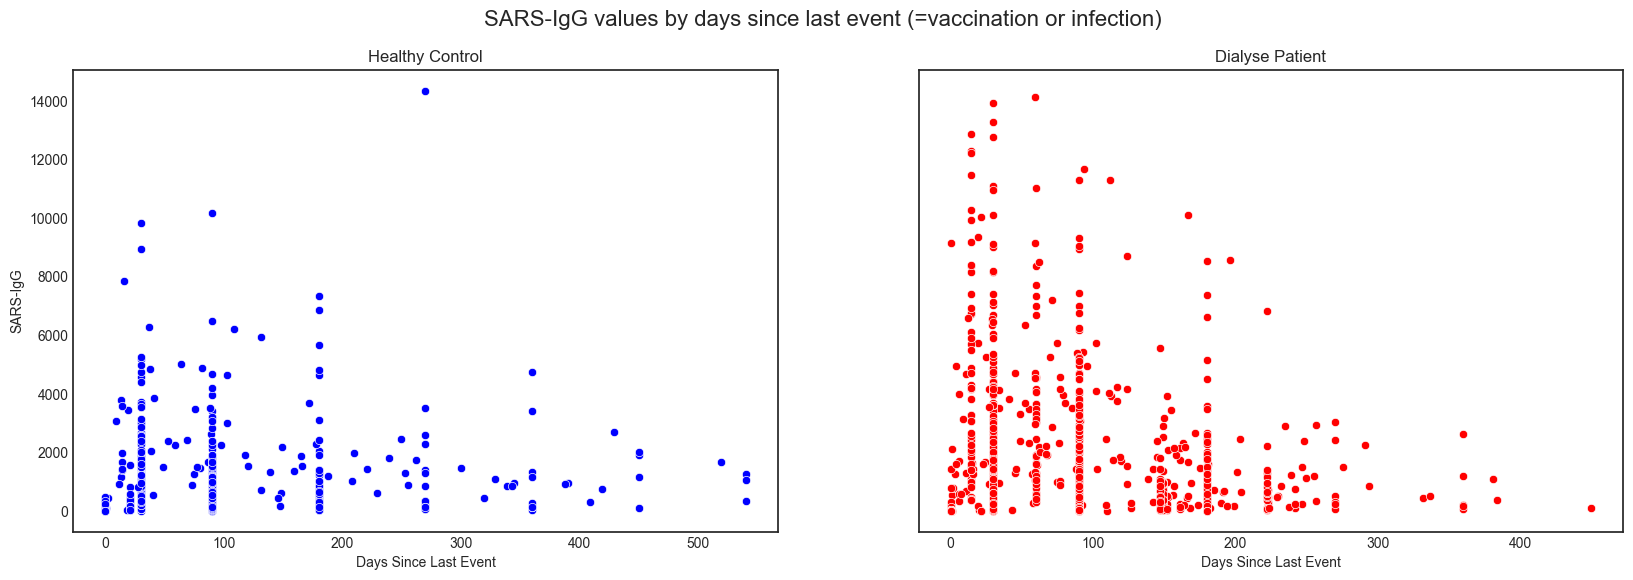

In [18]:
# Assuming 'result_df' is already loaded
sub_df = result_df[result_df['days_since_last_event'] != -1]
sub_df = sub_df[sub_df['SARS-IgG'] < 15000]

# Mapping for the legend
dialyse_mapping = {0: 'Healthy Control', 1: 'Dialyse Patient'}
sub_df['Dialyse'] = sub_df['Dialyse'].map(dialyse_mapping)

for i in [True, False]:
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

    # Set the background color to white
    fig.patch.set_facecolor('white')

    sns.scatterplot(data=sub_df[sub_df['Dialyse'] == 'Healthy Control'],
                    y='SARS-IgG', x='days_since_last_event', ax=axes[0], color='blue')
    sns.scatterplot(data=sub_df[sub_df['Dialyse'] == 'Dialyse Patient'],
                    y='SARS-IgG', x='days_since_last_event', ax=axes[1], color='red')

    if i:
        axes[0].set_yscale('log')
        axes[1].set_yscale('log')

    axes[0].set_title('Healthy Control')
    axes[1].set_title('Dialyse Patient')

    for ax in axes:
        ax.set_xlabel('Days Since Last Event')
        ax.set_ylabel('SARS-IgG')

    fig.suptitle('SARS-IgG values by days since last event (=vaccination or infection)', fontsize=16)

    os.chdir('C:/Users/joa24jm/PycharmProjects/immun-ml')
    figname = 'SARS-IgG_by_days_since_last_event'
    plt.savefig(f'results/plots/figures/{figname}_log-{i}_.svg')

    plt.show()

## What is the average increase in SARS-IgG after an infection?

In [14]:
res_df = pd.DataFrame(columns=['ID', 'slope', 'sars_diff'])
days_diff = list()
for id in result_df['ID'].unique():

    sub_df = result_df[result_df['ID']==id]

    # timepoint where infection happened
    infection_dates = list(sub_df[sub_df['infection']==1]['date'])

    for infection_date in infection_dates:
        try:
            res = h.calc_average_sarsigg_increase(sub_df, infection_date)

            if res:
                res['ID'] = id
                res['Dialyse'] = sub_df.Dialyse.unique().tolist()[0]
                days_diff.append(res['days_diff'])
                # Create a DataFrame for the row and use pd.concat to add it to res_df
                row_df = pd.DataFrame([res])  # Encapsulate 'res' in a list to treat it as a row
                res_df = pd.concat([res_df, row_df], ignore_index=True)
        except:
            pass

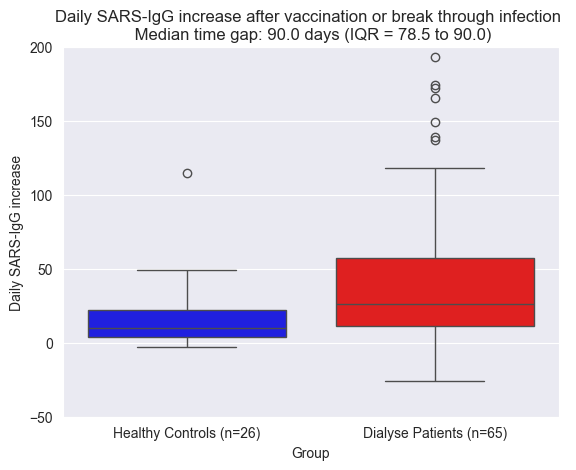

In [15]:
# Calculate median time between two measurements to which was used to calculate the slope
ser = pd.Series(days_diff)
median = ser.median()
Q25 = ser.quantile(0.25)
Q75 = ser.quantile(0.75)

# Count the number of observations in each group
res_df2= res_df
group_counts = res_df2['Dialyse'].value_counts().sort_index()

# Create the boxplot
ax = sns.boxplot(data=res_df2, x='Dialyse', y='slope', palette=['blue', 'red'])

# Set y-axis limits
ax.set_ylim([-50, 200])

# Set labels
plt.title(f'Daily SARS-IgG increase after vaccination or break through infection \n Median time gap: {median} days (IQR = {Q25} to {Q75})')
plt.ylabel('Daily SARS-IgG increase')
plt.xticks([0, 1], [f'Healthy Controls (n={group_counts[0]})', f'Dialyse Patients (n={group_counts[1]})'])
plt.xlabel('Group')

figname='Daily SARS-IgG Increase'
plt.savefig(f'results/plots/figures/{figname}.svg')

# Show the plot
plt.show()


### Is the difference between dialyse and non-dialyse in SARS-IgG increase significant?


In [16]:


res_df[res_df['slope'] < 500]

dialyse = list(res_df[res_df['Dialyse'] == 1]['slope'])
non_dialyse = list(res_df[res_df['Dialyse'] == 0]['slope'])

ttest_ind(dialyse, non_dialyse, equal_var=False)

TtestResult(statistic=1.7046143510856324, pvalue=0.09288545689586088, df=67.208286452235)

Groups are not statistically significant from each other!

In [17]:
res_df

,ID,slope,sars_diff,days_diff,Dialyse
0,C10,-0.648667,-97.30,150.0,0.0
1,C114,18.664021,3620.82,194.0,0.0
2,C13,22.203778,1998.34,90.0,0.0
3,C132,9.744222,876.98,90.0,0.0
4,C137,3.597564,561.22,156.0,0.0
...,...,...,...,...,...
86,HD91,11.779091,518.28,44.0,1.0
87,HD92,19.776667,3559.80,180.0,1.0
88,HD94,36.733444,3306.01,90.0,1.0
89,HD97,139.438571,3904.28,28.0,1.0


## Check the distance in days between SARS-IgG measurements


In [18]:
# Ensure the date column is in datetime format
result_df['date'] = pd.to_datetime(result_df['date'])

# Sort the DataFrame by patient_id and date
result_df = result_df.sort_values(by=['ID', 'date'])

# Calculate the difference in days between the dates in consecutive rows for each patient
result_df['date_difference'] = result_df.groupby('ID')['date'].diff().dt.days

# Calculate the difference in days relative to the first measurement date for each patient
result_df['days_since_first_measurement'] = result_df.groupby('ID')['date'].transform(lambda x: (x - x.min()).dt.days)

In [19]:
pd.cut(result_df['days_since_first_measurement'], np.arange(0, 720, 30)).value_counts().sort_index()

days_since_first_measurement
(0, 30]       461
(30, 60]      245
(60, 90]       58
(90, 120]     188
(120, 150]     52
(150, 180]      9
(180, 210]    203
(210, 240]     81
(240, 270]    150
(270, 300]    138
(300, 330]    108
(330, 360]    145
(360, 390]    108
(390, 420]    126
(420, 450]    137
(450, 480]     36
(480, 510]     92
(510, 540]     57
(540, 570]     28
(570, 600]     85
(600, 630]     95
(630, 660]    127
(660, 690]     82
Name: count, dtype: int64

### What is the SARS-IgG course over the study?

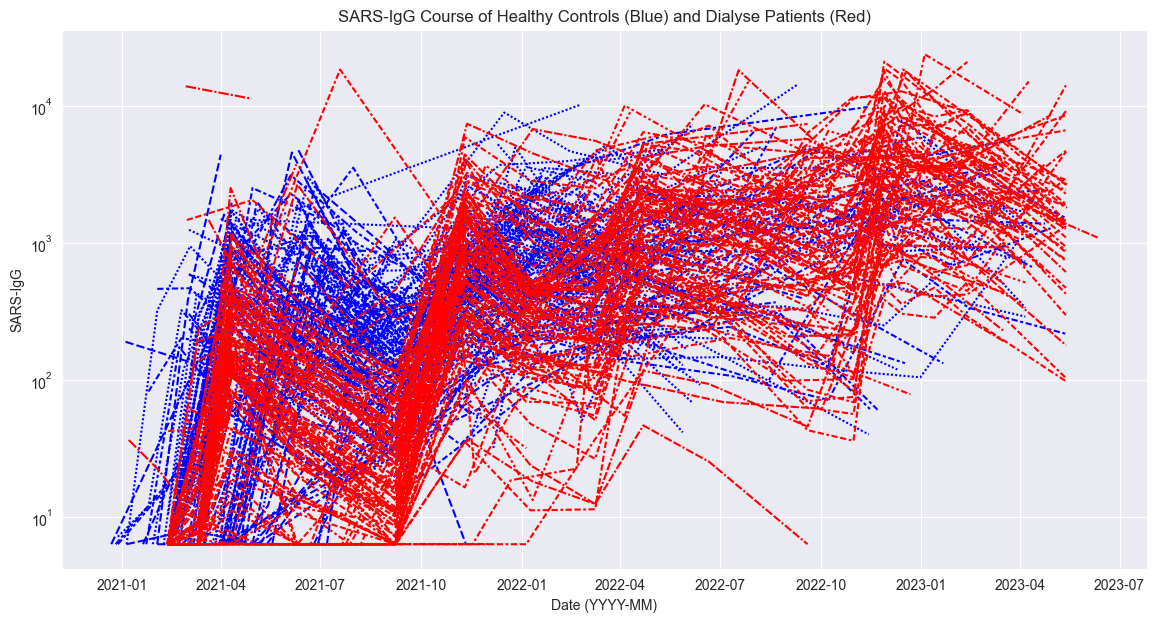

In [20]:
# Setting the plot size
plt.figure(figsize=(14, 7))

# Create a custom color palette
# Assuming 'Dialyse' column has binary values 0 or 1
palette = {id: 'red' if result_df[result_df.ID==id].Dialyse.unique()[0] == 1 else 'blue'
           for id in result_df['ID'].unique()}

# Plotting SARS-IgG values over time
ax = sns.lineplot(data=result_df[result_df['SARS-IgG'] < 30000], x='date', y='SARS-IgG', hue='ID', style='group_id', palette=palette)

# Set the y-axis to log scale
ax.set_yscale("log")

plt.title('SARS-IgG Course of Healthy Controls (Blue) and Dialyse Patients (Red)')
plt.xlabel('Date (YYYY-MM)')

# Remove the legend
ax.legend_.remove()

figname='SARS-IgG Course by Cohort'
plt.savefig(f'results/plots/figures/{figname}.svg')

# Show the plot
plt.show()

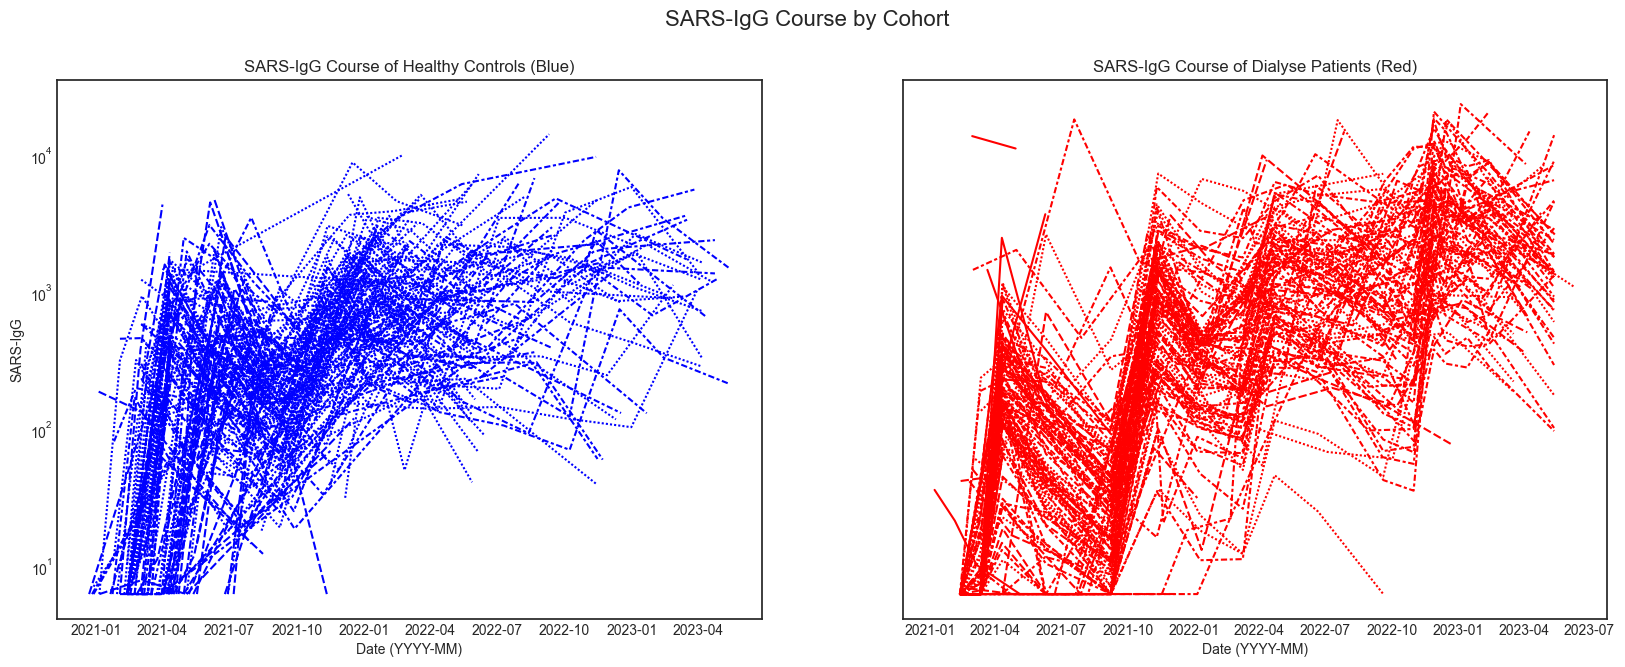

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Assuming 'result_df' is already loaded and preprocessed

# Setting the plot size for subfigures
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)

# Create custom color palettes for each group
palette_healthy = {id: 'blue' for id in result_df[result_df['Dialyse'] == 0]['ID'].unique()}
palette_dialyse = {id: 'red' for id in result_df[result_df['Dialyse'] == 1]['ID'].unique()}

# Plotting SARS-IgG values over time for Healthy Controls
sns.lineplot(data=result_df[(result_df['SARS-IgG'] < 30000) & (result_df['Dialyse'] == 0)],
             x='date', y='SARS-IgG', hue='ID', style='group_id', palette=palette_healthy, ax=axes[0])
axes[0].set_yscale("log")
axes[0].set_title('SARS-IgG Course of Healthy Controls (Blue)')
axes[0].set_xlabel('Date (YYYY-MM)')
axes[0].set_ylabel('SARS-IgG')

# Plotting SARS-IgG values over time for Dialyse Patients
sns.lineplot(data=result_df[(result_df['SARS-IgG'] < 30000) & (result_df['Dialyse'] == 1)],
             x='date', y='SARS-IgG', hue='ID', style='group_id', palette=palette_dialyse, ax=axes[1])
axes[1].set_yscale("log")
axes[1].set_title('SARS-IgG Course of Dialyse Patients (Red)')
axes[1].set_xlabel('Date (YYYY-MM)')
axes[1].set_ylabel('SARS-IgG')

# Remove legends to avoid clutter
axes[0].legend_.remove()
axes[1].legend_.remove()

fig.suptitle('SARS-IgG Course by Cohort', fontsize=16)

os.chdir('C:/Users/joa24jm/PycharmProjects/immun-ml')
figname = 'SARS-IgG_Course_by_Cohort'
plt.savefig(f'results/plots/figures/{figname}_.svg')

# Show the plot
plt.show()


### For each group

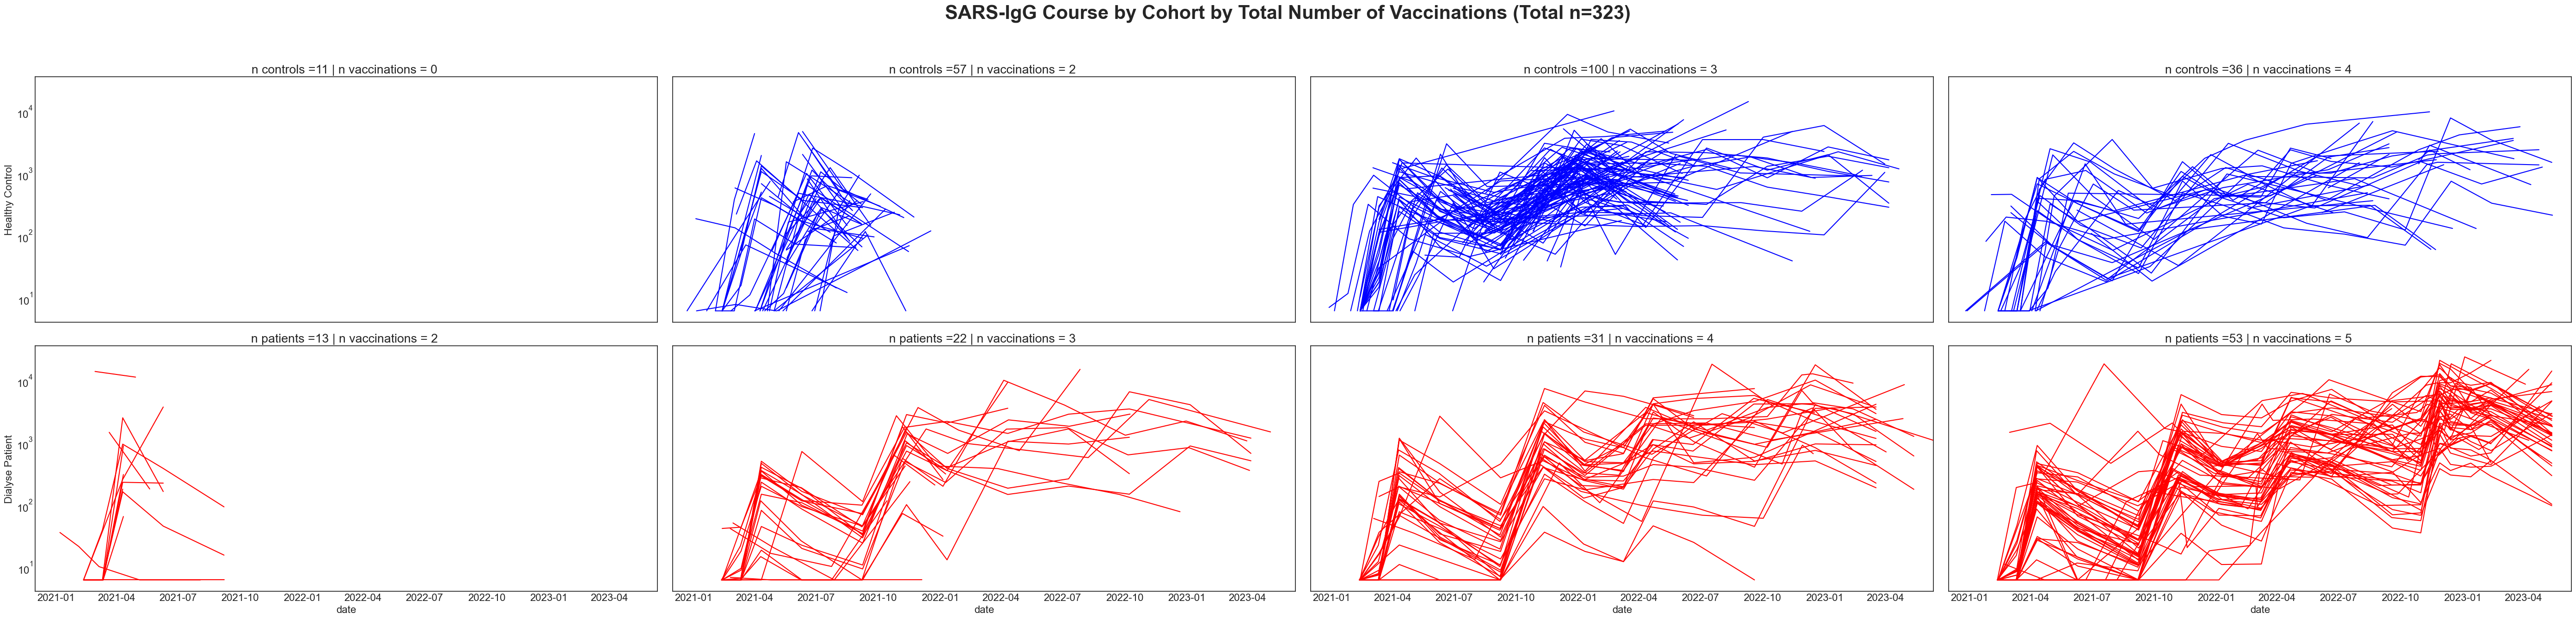

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the overall font size for better readability
plt.rcParams.update({'font.size': 16})

# Assuming 'result_df' is your DataFrame
group_ids = result_df['group_id'].unique()  # Get unique group IDs

# Separate the group_ids based on Dialyse status
dialyse_group_ids = result_df[result_df['Dialyse'] == 1]['group_id'].unique()
healthy_group_ids = result_df[result_df['Dialyse'] == 0]['group_id'].unique()

# Determine the number of columns based on the maximum of two groups
num_cols = max(len(dialyse_group_ids), len(healthy_group_ids))

# Setting the figure size appropriately
fig, axes = plt.subplots(nrows=2, ncols=num_cols, figsize=(14 * num_cols, 14), sharey=True, sharex=True)

# Create a custom color palette based on 'Dialyse' column
palette = {id: 'red' if result_df[result_df.ID == id].Dialyse.unique()[0] == 1 else 'blue'
           for id in result_df['ID'].unique()}

# Determine the overall min and max dates
overall_min_date = pd.to_datetime('2020-12')
overall_max_date = result_df['date'].max()

# Calculate the total number of unique patients
total_num_patients = result_df['ID'].nunique()

# Function to plot the data
def plot_group_data(axes, group_ids, row_idx, title, title_info = 'patients'):
    for col_idx, group_id in enumerate(group_ids):
        ax = axes[row_idx, col_idx]

        # Filter the data for the current group_id
        group_data = result_df[(result_df['group_id'] == group_id) & (result_df['SARS-IgG'] < 30000)]

        # Count the number of unique patients in the current group
        num_patients = group_data['ID'].nunique()

        # Plotting SARS-IgG values over time
        sns.lineplot(data=group_data, x='date', y='SARS-IgG', hue='ID', style='group_id', palette=palette, ax=ax)

        # Set the y-axis to log scale
        ax.set_yscale("log")
        ax.set_ylabel(f'{title}')

        # Set title for each subplot, including the number of patients and number of vaccinations for this group
        n_vacc = group_id_dict[group_id]['n_vaccinations']
        ax.set_title(f"n {title_info} ={num_patients} | n vaccinations = {n_vacc} ")

        # Set the x-axis limits to the overall min and max dates
        ax.set_xlim(overall_min_date, overall_max_date)

        # Remove the legend from each subplot to avoid clutter
        ax.legend_.remove()

    # Hide unused subplots in the row
    for unused_col_idx in range(len(group_ids), num_cols):
        axes[row_idx, unused_col_idx].axis('off')

# Sort the group_ids based on the number of vaccinations
sorted_healthy_group_ids = sorted(healthy_group_ids, key=lambda x: group_id_dict[x]['n_vaccinations'])
sorted_dialyse_group_ids = sorted(dialyse_group_ids, key=lambda x: group_id_dict[x]['n_vaccinations'])

# Plot healthy controls in the first row with sorted group_ids
plot_group_data(axes, sorted_healthy_group_ids, 0, 'Healthy Control', title_info='controls')

# Plot dialyse patients in the second row with sorted group_ids
plot_group_data(axes, sorted_dialyse_group_ids, 1, 'Dialyse Patient', title_info='patients')

# Add a suptitle with the total number of patients
fig.suptitle(f'SARS-IgG Course by Cohort by Total Number of Vaccinations (Total n={total_num_patients})', fontsize=30, fontweight='bold')

# Adjust layout with more space between suptitle and subfigures
plt.tight_layout(rect=[0, 0.02, 1, 0.95])

figname='SARS-IgG Course by Groups by vaccinations'
plt.savefig(f'results/plots/figures/{figname}_.svg')

# Show the plot
plt.show()


## Prepare dataset for ML

In [23]:
# Apply the function to each group
result_df['future_measurement_date'] = result_df.groupby('ID').apply(h.find_future_measurement_date).reset_index(level=0, drop=True)

In [24]:
def find_future_measurement(id, future_measurement_date):
    return result_df[(result_df['ID']==id) & (result_df['date']==future_measurement_date)]['SARS-IgG'].iloc[0]

idxs = result_df.dropna(subset='future_measurement_date').index

result_df['future_measurement_val'] = None

for idx in idxs:
    id = result_df.loc[idx, 'ID']
    future_measurement_date = result_df.loc[idx, 'future_measurement_date']
    result_df.loc[idx, 'future_measurement_val'] = find_future_measurement(id, future_measurement_date)



In [25]:
# convert 'date' format
result_df['date'] = result_df['date'].dt.strftime('%Y-%m-%d')

In [26]:
# get baseline information
result_df = pd.merge(result_df, bl[['Alter','Geschlecht','Dialyse']], left_on='ID', right_index=True, how='left')

In [27]:
# read in basline table to get demographic data
path = 'G://My Drive//Forschung//Mitarbeiter//Allgaier//23-12-06_Immun-ML//04_Data//03_ML//'
result_df.to_excel(path+f'{name}_ML.xlsx')